In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import itertools
from gensim.models import Word2Vec, KeyedVectors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [29]:
wv2 = KeyedVectors.load_word2vec_format('~/toys/mienv3/datasets/PubMed-w2v.bin', binary=True)

In [8]:
wv2.wv.most_similar(positive='gene')

[('genes', 0.7986274361610413),
 ('gene-encoding', 0.7325981259346008),
 ('ETF1', 0.7128434181213379),
 ('men1', 0.6953920722007751),
 ('nagR', 0.6919228434562683),
 ('NVL3', 0.6910488605499268),
 ('Assignment1', 0.68581622838974),
 ('Monoallelic', 0.685641884803772),
 ('Eif4g3', 0.6844524145126343),
 ('sericin-1', 0.6842490434646606)]

In [65]:
def get_cleaned_text2(fname, max_len=999999):
    all_words = []
    with open(fname, 'r') as f:
        for n, line in enumerate(f):
            if n and n<max_len:
                line_id, line_text = line.split('||')
                line_letters = re.sub("[^a-zA-Z -]", "", line_text) 
                line_letters_low = line_letters.lower()
                line_letters_low = stop_pattern.sub('', line_letters_low)
                line_words = line_letters_low.split()
                all_words.append(line_words)
                #all_words.append(line_letters_low)
                #print(len(all_words), len(line_letters_low))
    return all_words

def get_text_features(fname = '../data/training_text'):
    '''
    as a first approximation, let's estimate the mean vector of each text; 
    for later TODO some fancy projections
    '''
    wv_dim = wv2.wv.vector_size
    whole_text = get_cleaned_text2(fname)
    data_features = np.empty(shape=(len(whole_text), wv_dim))
    #wv_vocab = [w.lower() for w in list(wv2.vocab.keys())]
    for i, text in enumerate(whole_text[:2]):
        data_features[i,:] = np.array([wv2.wv[w] for w in text if w in wv2.wv.vocab]).mean(axis=0)
        print(len(text), len([wv2.wv[w] for w in text if w in wv2.vocab]))
    return data_features


stop_words = ['et', 'al', 'fig', 'figs', 'figure', 'table', 'also',
            'using', 'found', 'observed', 'however', 'previous', 'study',
            'although', 'studies', 'several', 'showed', 'could', 
            'performed', 'known', 'methods', 'whether', 'materials',
            'known', 'analyzed', 'within', 'show', 'respectively', 
            'thus', 'therefore', 'tested', 'among', 'abstract', 
            'introduction', 'may', 'shown', 'results', 'interestingly',
            'either', 'similarly', 'furthermore', 'consistently', 
            'neither']

stop_pattern = re.compile(r'\b(' + r'|'.\
            join(stopwords.words('english')+stop_words) + r')\b\s*')

train_data_features = get_text_features(fname = '../data/training_text')

#train_text2 = get_cleaned_text2(fname)

3461 3173
3169 3009


In [58]:
'gst-cdk' in wv2.wv.vocab

False

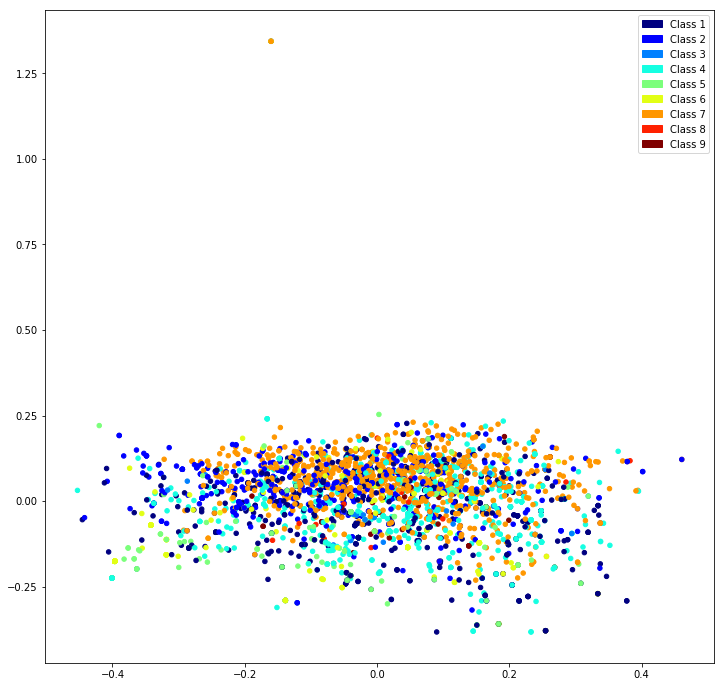

In [8]:
train_variants = pd.read_csv('../data/training_variants')
classes = train_variants.Class.values

pca = PCA(n_components=2)
reduced_vecs = pca.fit_transform(train_data_features)

from matplotlib.patches import Patch

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
cm = plt.get_cmap('jet', 9)
colors = [cm(i/9) for i in range(9)]
ax.scatter(reduced_vecs[:,0], reduced_vecs[:,1], c=[colors[c-1] for c in classes], cmap='jet', s=20)
#plt.legend(['Class ' +str(i+1) for i in range(9)])
plt.legend(handles=[Patch(color=colors[i], label='Class {}'.format(i+1)) for i in range(9)])

In [45]:
forest = RandomForestClassifier(n_estimators=100) 
forest = forest.fit(train_data_features, train_variants["Class"])

result_tr = forest.predict(train_data_features)
print("corr between prediction and real: ", np.corrcoef(result_tr, np.array(train_variants["Class"]))[0,1])

scores = cross_val_score(forest, train_data_features, train_variants["Class"], cv=10, n_jobs=2)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

corr between prediction and real:  0.877251345961
[ 0.42261905  0.46428571  0.38622754  0.42642643  0.37537538  0.41566265
  0.52870091  0.59393939  0.55927052  0.37920489]
Accuracy: 0.46 (+/- 0.07)


PubMed w2v model seems didn't improve the results compared to w2v trained on the data..

TODO: loaded w2v model uses upper/lower cases..figure out how to consider only lower instead

I can try to produce a solution anyway..hope the RAM will survive

In [10]:
test_data_features = get_text_features('../data/test_text')

In [42]:
result = forest.predict(test_data_features)
result_mat = np.zeros((len(result), 9))
    
test_id = np.arange(len(result))

result_mat[test_id, result-1] = 1
result_mat = result_mat.astype(int)
output = pd.DataFrame( data={"ID":test_id, "class1":result_mat[:,0],
        "class2":result_mat[:,1],
        "class3":result_mat[:,2],
        "class4":result_mat[:,3],
        "class5":result_mat[:,4],
        "class6":result_mat[:,5],
        "class7":result_mat[:,6],
        "class8":result_mat[:,7],
        "class9":result_mat[:,8]
        } )
output.to_csv( "pubmed_w2v_on_text_cases_mixed.csv", index=False)

In [14]:
train_data_features[0]

array([ -4.94713970e-02,   1.40805934e-02,  -3.80985066e-02,
        -1.38008350e-03,  -1.67235047e-01,  -3.52673419e-03,
        -9.45151597e-02,  -7.84332901e-02,   4.02512290e-02,
        -3.67538482e-02,   7.53008798e-02,   8.71239081e-02,
        -3.91828381e-02,   6.31278008e-02,   5.26032737e-03,
        -4.62985113e-02,  -3.21426317e-02,   4.47356589e-02,
         4.42279503e-02,   6.05305843e-03,   6.38758466e-02,
        -1.24425273e-02,   3.07911467e-02,   2.07143533e-03,
        -2.03445200e-02,  -6.35208935e-02,   7.91978166e-02,
         1.94221102e-02,  -7.25236535e-02,   1.07926756e-01,
         9.05904081e-03,  -2.17135698e-02,  -1.43220532e-04,
        -1.05192205e-02,  -3.23195346e-02,   3.35231237e-02,
        -5.08997962e-02,   5.98578155e-02,  -9.10095125e-02,
        -3.86926271e-02,   6.11082214e-05,  -5.45057729e-02,
         1.88360177e-02,  -4.48472686e-02,   1.55439705e-03,
        -7.21661299e-02,  -1.87373310e-02,  -4.64250557e-02,
        -5.80882095e-02,

In [40]:
list(wv2.vocab.keys())

['</s>',
 '.',
 'of',
 'the',
 ',',
 'and',
 'in',
 'to',
 ')',
 '(',
 'a',
 'with',
 'for',
 'was',
 'The',
 'were',
 'by',
 'is',
 'that',
 'on',
 '%',
 'from',
 'patients',
 'as',
 'or',
 'are',
 'be',
 'an',
 'at',
 'not',
 'cells',
 'this',
 'In',
 ':',
 'study',
 ']',
 '[',
 'A',
 'which',
 'have',
 'than',
 ';',
 'after',
 'between',
 'treatment',
 'these',
 'cell',
 'but',
 'We',
 'been',
 'has',
 'results',
 '=',
 'This',
 'may',
 'during',
 'using',
 'had',
 'activity',
 'group',
 'both',
 'also',
 'two',
 'their',
 'can',
 'disease',
 '1',
 'we',
 'more',
 'protein',
 'used',
 '2',
 'levels',
 'increased',
 'effect',
 'effects',
 'human',
 'found',
 'clinical',
 'analysis',
 'other',
 'expression',
 'significantly',
 'all',
 'no',
 'associated',
 '+/-',
 'data',
 "'s",
 'significant',
 '"',
 'compared',
 '<',
 'its',
 'studies',
 'different',
 'These',
 'showed',
 'control',
 'P',
 'it',
 'one',
 'cases',
 'into',
 'years',
 'high',
 'cancer',
 'blood',
 'use',
 '3',
 'gene'

In [62]:
wv2.wv.